Importamos las librerías que vamos a necesitar

In [1]:
import numpy as np
import ctypes
import time
import statistics
import matplotlib.pyplot as plt

In [2]:
value = np.random.randint(100)

Creamos nuestra función de varianza en C

In [3]:
%%file cLimitebin.c
#include <stdio.h>
#include <stdlib.h>

double binaryExp(double a, int b){
    if(b==0) return 1;
    double tmp = binaryExp(a,b/2);
    double result = tmp*tmp;
    if(b%2 == 1) result *= a;
    return result;    
}

double cLimiteBin(int N){
    double base = 1.0 + 1.0/(double)N;
    double result = binaryExp(base, N);

    return result;
}

Overwriting cLimitebin.c


Linkeamos el ejecutable de C como una librería compartida para usar en python

In [4]:
! gcc -c -Wall -Werror -fpic cLimitebin.c
! gcc -shared cLimitebin.o -o cLimitebin.so

Definimos la función con ctypes en python

In [5]:
def ctypes_cLimitebin():
    # ruta de la shared library
    lib = ctypes.CDLL('./cLimitebin.so')
    
    # tipo de los argumentos
    lib.cLimiteBin.argtypes = [
        ctypes.c_int
    ]

    # definimos el tipo de salida de la función
    lib.cLimiteBin.restype = ctypes.c_double

    # se devuelve la función configurada
    return lib.cLimiteBin

In [6]:
cLimitebin = ctypes_cLimitebin()

Probamos nuestra función

In [7]:
print("Valor:",end = " ")
print(value)
print("Limite:",end = " ")
print(cLimitebin(value))

Valor: 72
Limite: 2.6996420591266297


Implementamos la misma función en lenguaje ensamblador

In [8]:
%%file asmLimiteBin.asm
global asmLimiteBin  
section .text
asmLimiteBin:
    xorpd xmm0,xmm0
    xorpd xmm1,xmm1
    xorpd xmm3,xmm3
    xor r8,r8
    xor r12,r12
    xor r13,r13
    mov r12, rdi
    mov r13, r12
    mov r8, 1
    cvtsi2sd xmm3,r8
    cvtsi2sd xmm0, rdi
    
base:
    movsd xmm1, xmm3
    divsd xmm1, xmm0
    addsd xmm1, xmm3 ; base en xmm1
    
    ;movsd xmm0,xmm1
    ;jmp done
    
binExp:             ;while
    cmp r12,0       ;     (b > 0){
    jbe next1       ;
    and r13,01H     ;if(b & 1){
    cmp r13,01H     ;
    jne next2       ;
    mulsd xmm3,xmm1 ; res = res * a}
    next2:          ;
    mulsd xmm1,xmm1 ; a = a * a
    shr r12,1       ; b >>=1}
    mov r13,r12     ;
    jmp binExp      ;
next1:    
    movsd xmm0,xmm3 ;return res
done:
    ret 

Overwriting asmLimiteBin.asm


In [9]:
%%file asmLimiteBin.c
extern double asmLimiteBin(int N);

Overwriting asmLimiteBin.c


In [10]:
! nasm -f elf64 -g asmLimiteBin.asm -o asmLimiteBin.o
! gcc -shared asmLimiteBin.o asmLimiteBin.c -o asmLimiteBin.so

Definimos la función con ctypes en python

In [11]:
def ctypes_asmLimite():
    # ruta de la shared library
    lib = ctypes.CDLL('./asmLimiteBin.so')
    
    # tipo de los argumentos
    lib.asmLimiteBin.argtypes = [
        ctypes.c_int
    ]

    # definimos el tipo de salida de la función
    lib.asmLimiteBin.restype = ctypes.c_double

    # se devuelve la función configurada
    return lib.asmLimiteBin

In [19]:
asmLimiteBin = ctypes_asmLimite()

Probamos nuestra función

In [20]:
print("Valor:",end = " ")
print(value)
print("Limite:",end = " ")
print(asmLimiteBin(value))

Valor: 100
Limite: 2.704813829421529


# Comparación de tiempos de ejecución

In [21]:
def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [22]:
# size of arrays
sizes = 2**np.arange(11,18)

# tiempo en C
time_c = np.zeros((len(sizes),1),dtype = np.float64)

# tiempo con ruido en C
time_c_noise = np.zeros((len(sizes),1),dtype = np.float64)

# tiempo en ASM
time_asm = np.zeros((len(sizes),1),dtype = np.float64)

# tiempo con ruido en ASM
time_asm_noise = np.zeros((len(sizes),1),dtype = np.float64)

In [23]:
veces = 50
tam = sizes[0]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):

    # entradas
    xp = np.random.randint(50)
    
    # tiempo C
    t = time.time()
    cLimitebin(xp)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    asmLimiteBin(xp)
    tasmp.append(time.time() - t)

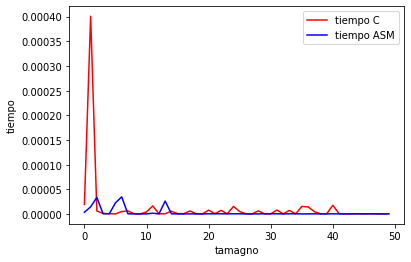

In [24]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()

# SpeedUp

In [25]:
c_mean = statistics.mean(tcp)
asm_mean = statistics.mean(tasmp)

In [26]:
speed_up = c_mean/asm_mean

In [27]:
speed_up

3.6937590711175616